# Extending linear models

## Imports

In [14]:
%config InlineBackend.figure_format="retina"

In [20]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

## Transforming covariates

Can transform covariates—$\mathbf{X}$—to
make relationship between $\mathbf{X}$ and $Y$ nonlinear—such
as taking the square root
or log.

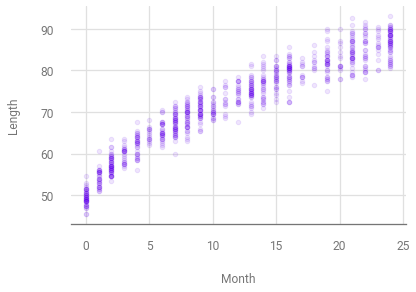

In [10]:
babies = pd.read_csv(
    "https://raw.githubusercontent.com"
    "/BayesianModelingandComputationInPython/BookCode_Edition1/main"
    "/data/babies.csv"
).assign(Intercept=1)
babies.plot.scatter(x="Month", y="Length", alpha=0.1);

In [13]:
with pm.Model() as model_baby_linear:
    β = pm.Normal("β", sigma=10, shape=2)

    μ = pm.Deterministic("μ", pm.math.dot(babies[["Intercept", "Month"]], β))
    ϵ = pm.HalfNormal("ϵ", sigma=10)

    length = pm.Normal("length", mu=μ, sigma=ϵ, observed=babies["Length"])

    trace_linear = pm.sample(draws=2_000, tune=4_000)
    pcc_linear = pm.sample_posterior_predictive(trace_linear)
    inf_data_linear = az.from_pymc3(trace=trace_linear, posterior_predictive=pcc_linear)

/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 38 seconds.


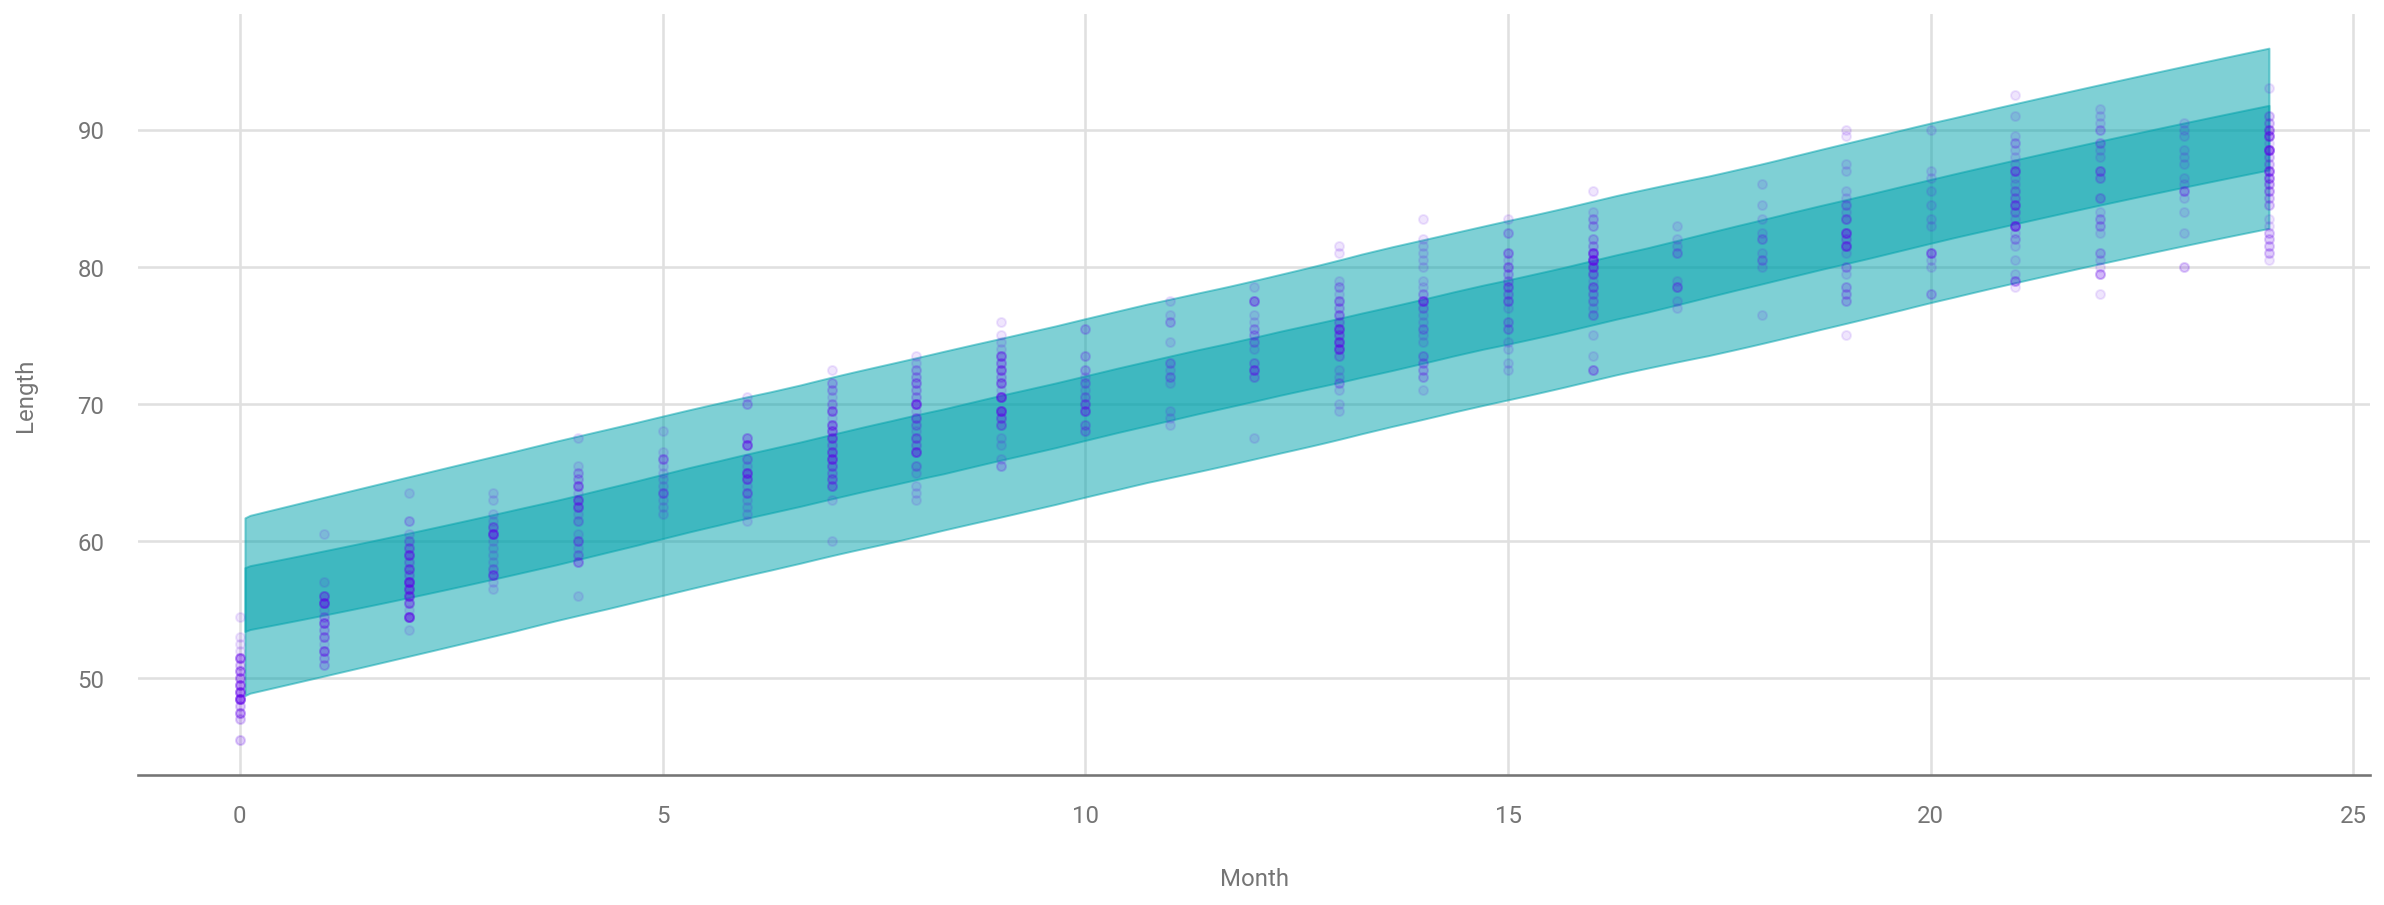

In [18]:
_, ax = plt.subplots(figsize=(20, 7))

for hdi_prob in [0.50, 0.94]:
    az.plot_hdi(
        babies["Month"],
        inf_data_linear["posterior_predictive"]["length"],
        hdi_prob=hdi_prob,
        ax=ax,
    )
babies.plot.scatter(x="Month", y="Length", alpha=0.1, ax=ax);

/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 28 seconds.
The acceptance probability does not match the target. It is 0.8942696754162789, but should be close to 0.8. Try to increase the number of tuning steps.


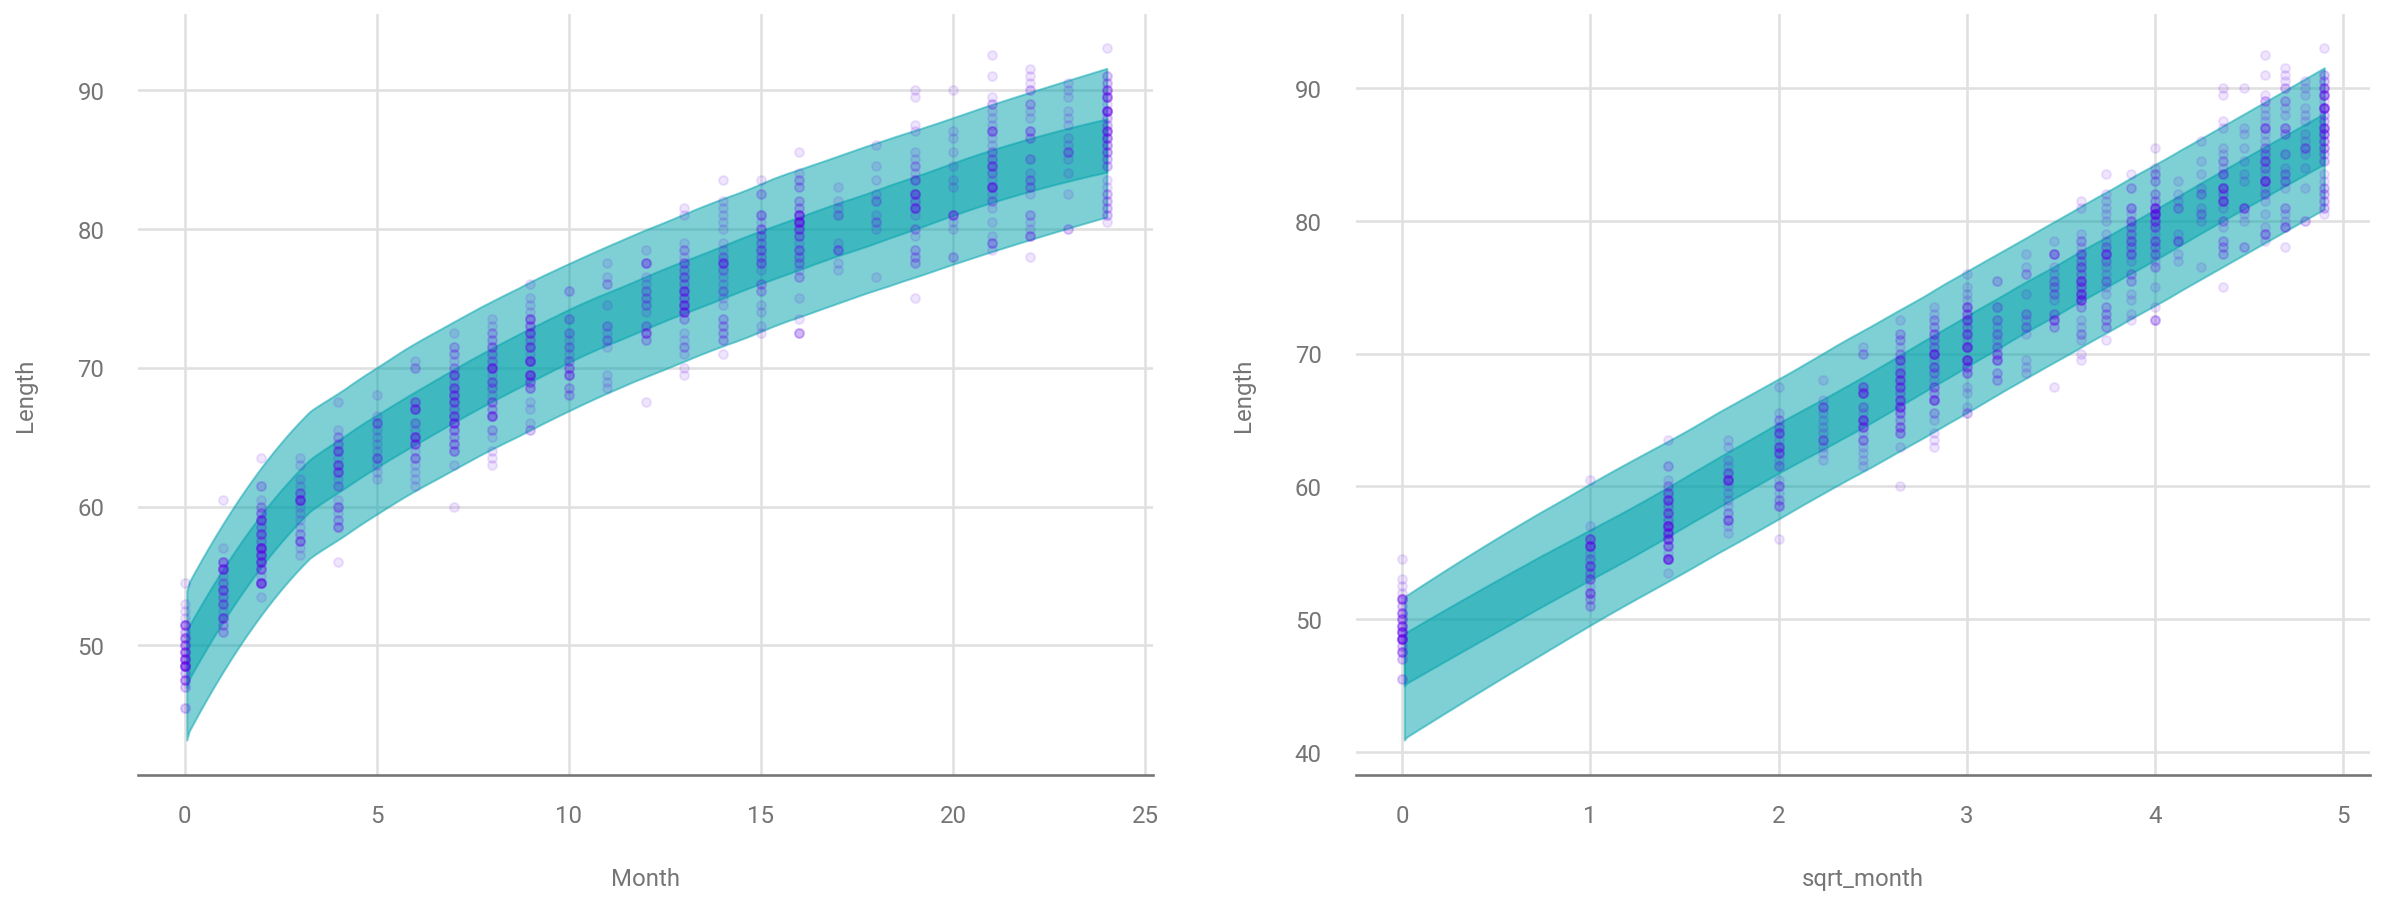

In [28]:
with pm.Model() as model_baby_sqrt:
    β = pm.Normal("β", sigma=10, shape=2)

    μ = pm.Deterministic("μ", β[0] + β[1] * np.sqrt(babies["Month"]))
    σ = pm.HalfNormal("σ", sigma=10)

    length = pm.Normal("length", mu=μ, sigma=σ, observed=babies["Length"])

    inf_data_sqrt = pm.sample(draws=2000, tune=4000)
    ppc_baby_sqrt = pm.sample_posterior_predictive(inf_data_sqrt)
    inf_data_sqrt = az.from_pymc3(
        trace=inf_data_sqrt, posterior_predictive=ppc_baby_sqrt
    )

_, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(20, 7))

for hdi_prob in [0.50, 0.94]:
    az.plot_hdi(
        babies["Month"],
        inf_data_sqrt["posterior_predictive"]["length"],
        hdi_prob=hdi_prob,
        ax=ax_left,
    )
babies.plot.scatter(x="Month", y="Length", alpha=0.1, ax=ax_left)
for hdi_prob in [0.50, 0.94]:
    az.plot_hdi(
        np.sqrt(babies["Month"]),
        inf_data_sqrt["posterior_predictive"]["length"],
        hdi_prob=hdi_prob,
        ax=ax_right,
    )
(
    babies.assign(sqrt_month=lambda df: np.sqrt(df["Month"])).plot.scatter(
        x="sqrt_month", y="Length", alpha=0.1, ax=ax_right
    )
);

## Varying uncertainty

Before we assumed variance is constant
thourought the range.
But we can also make it variable:

$$
\begin{split}
    \mu =& \beta_0 + \beta_1 f_1(X_1) + \dots + \beta_m f_m(X_m) \\
    \sigma =& \delta_0 + \delta_1 g_1(X_1) + \dots + \delta_m g_m(X_m) \\
Y \sim& \mathcal{N}(\mu, \sigma)
\end{split}
$$

/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [δ, β]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 43 seconds.


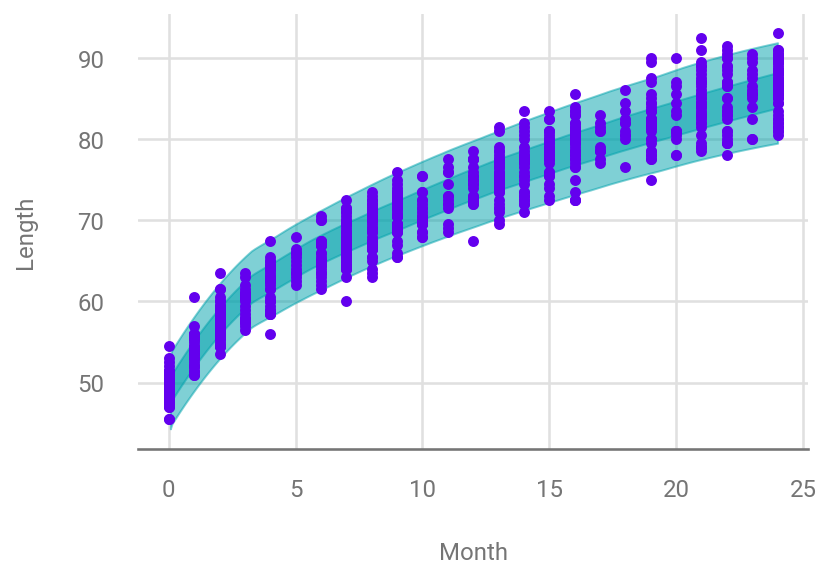

In [31]:
with pm.Model() as model_baby_vv:
    β = pm.Normal("β", sigma=10, shape=2)

    δ = pm.HalfNormal("δ", sigma=10, shape=2)
    μ = pm.Deterministic("μ", β[0] + β[1] * np.sqrt(babies["Month"]))
    σ = pm.Deterministic("σ", δ[0] + δ[1] * babies["Month"])

    length = pm.Normal("length", mu=μ, sigma=σ, observed=babies["Length"])

    trace_baby_vv = pm.sample(2000, target_accept=0.95)
    ppc_baby_vv = pm.sample_posterior_predictive(
        trace_baby_vv, var_names=["length", "σ"]
    )
    inf_data_baby_vv = az.from_pymc3(
        trace=trace_baby_vv, posterior_predictive=ppc_baby_vv
    )

_, ax = plt.subplots()
for hdi_prob in [0.50, 0.94]:
    az.plot_hdi(
        babies["Month"],
        inf_data_baby_vv.posterior_predictive["length"],
        hdi_prob=hdi_prob,
        ax=ax,
    )
babies.plot.scatter(x="Month", y="Length", ax=ax);

## Interaction effects

Covariates are not always independent.

$$
\begin{split}
    \mu =& \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_1X_2\\
    Y \sim& \mathcal{N}(\mu, \sigma)
\end{split}
$$

In [34]:
tips_df = pd.read_csv(
    "https://raw.githubusercontent.com"
    "/BayesianModelingandComputationInPython/BookCode_Edition1/main"
    "/data/tips.csv"
)
tips = tips_df["tip"]
total_bill_c = tips_df["total_bill"] - tips_df["total_bill"].mean()  # Center bill
smoker = pd.Categorical(tips_df["smoker"]).codes

with pm.Model() as model_no_interactions:
    β = pm.Normal("β", mu=0, sigma=1, shape=3)
    σ = pm.HalfNormal("σ", 1)

    μ = β[1] + β[1] * total_bill_c + β[2] * smoker

    obs = pm.Normal("obs", μ, σ, observed=tips)
    trace_no_interaction = pm.sample(1_000, tune=1_000)

with pm.Model() as model_interaction:
    β = pm.Normal("β", mu=0, sigma=1, shape=4)
    σ = pm.HalfNormal("σ", 1)

    μ = β[0] + β[1] * total_bill_c + β[2] * smoker + β[3] * smoker * total_bill_c

    obs = pm.Normal("obs", μ, σ, observed=tips)
    trace_interaction = pm.sample(1000, tune=1000)

/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


![Smoker Tip Interaction](images/chapter_4/Smoker_Tip_Interaction.png)
